In [3]:
from IPython.core.display import Image
import sys

import numpy as np
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like # remove once updated pandas-datareader issue is fixed
# https://github.com/pydata/pandas-datareader/issues/534
import pandas_datareader.data as web
%matplotlib inline

In [11]:
def get_symbols(symbols, data_source, begin_date=None, end_date=None):
    out = pd.DataFrame()
    for symbol in symbols:
        df = web.DataReader(symbol, data_source, begin_date, end_date, api_key='2gwP5WpwYPiHshKy1H9v')\
        [['AdjOpen','AdjHigh','AdjLow','AdjClose','AdjVolume']].reset_index()
        df.columns = ['date','open','high','low','close','volume'] #my convention: always lowercase
        df['symbol'] = symbol # add a new column which contains the symbol so we can keep multiple symbols in the same dataframe
        df = df.set_index(['date', 'symbol'])
        out = pd.concat([out, df], axis=0) #stacks on top of previously collected data
    return out.sort_index()
        
prices = get_symbols(['AAPL','CSCO','AMZN','YHOO','MSFT'],data_source='quandl',begin_date='2012-01-01',end_date=None)
# note, we're only using real price data to get an accurate date/symbol index set.  

print(prices.shape)

(7639, 5)


In [12]:
num_obs = prices.close.count()

def add_memory(s, n_days=50, memory_strength=0.1):
    ''' adds autoregressive behavior to series of data'''
    add_ewm = lambda x: (1 - memory_strength)*x + memory_strength*x.ewm(n_days).mean()
    out = s.groupby(level='symbol').apply(add_ewm)
    return out

# generate feature data
f01 = pd.Series(np.random.randn(num_obs),index=prices.index)
f01 = add_memory(f01, 10, 0.1)
f02 = pd.Series(np.random.randn(num_obs),index=prices.index)
f02 = add_memory(f02, 10, 0.1)
f03 = pd.Series(np.random.randn(num_obs),index=prices.index)
f03 = add_memory(f03, 10, 0.1)
f04 = pd.Series(np.random.randn(num_obs),index=prices.index)
f04 = f04 # no memory

## now, create response variable such that it is related to features
# f01 becomes increasingly important, f02 becomes decreasingly important,
# f03 oscillates in importance, f04 is stationary, finally a noise component is added

outcome =   f01 * np.linspace(0.5,1.5,num_obs) + \
            f02 * np.linspace(1.5,0.5,num_obs) + \
            f03 * pd.Series(np.sin(2*np.pi*np.linspace(0,1,num_obs)*2)+1, index=f03.index) + \
            f04 + \
            np.random.randn(num_obs) * 3 
outcome.name = 'outcome'

In [13]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
features = pd.concat([f01,f02,f03,f04],axis=1)
features.columns = ['f01','f02','f03','f04']
model.fit(X=features, y=outcome)
print('RSQ: ' + str(model.score(X=features, y=outcome)))
print('Regression Coefficients: ' + str(model.coef_))

RSQ: 0.27272891884414696
Regression Coefficients: [0.95664641 1.01037377 0.98200077 1.01988916]


In [14]:
split_point = int(0.80*len(outcome))

X_train = features.iloc[:split_point,:] 
y_train = outcome.iloc[:split_point] 
X_test = features.iloc[split_point:,:] 
y_test = outcome.iloc[split_point:] 

model = LinearRegression()
model.fit(X=X_train,y=y_train)

print('RSQ in sample: '+str(model.score(X=X_train, y=y_train)))
print('RSQ out of sample: '+str(model.score(X=X_test, y=y_test)))
print('Regression Coefficients: '+str(model.coef_))

RSQ in sample: 0.29527476718135715
RSQ out of sample: 0.15068994516468515
Regression Coefficients: [0.88504962 1.12591189 1.14844227 1.0063754 ]


In [47]:
recalc_dates = features.resample('Q', level='date').mean().index
print('recalc_dates:')
print(recalc_dates)
#print()

models = pd.Series(index=recalc_dates)

for date in recalc_dates:
    X_train = features.xs(slice(None,date), level='date', drop_level=False)
    y_train = outcome.xs(slice(None,date), level='date', drop_level=False)
    model = LinearRegression()
    model.fit(X_train, y_train)
    models.loc[date] = model
    
    print("Training on the first {} records, through {}"\
          .format(len(y_train),y_train.index.get_level_values('date').max()))
    #print("Coefficients: {}".format((model.coef_)))
    #print()


recalc_dates:
DatetimeIndex(['2012-03-31', '2012-06-30', '2012-09-30', '2012-12-31',
               '2013-03-31', '2013-06-30', '2013-09-30', '2013-12-31',
               '2014-03-31', '2014-06-30', '2014-09-30', '2014-12-31',
               '2015-03-31', '2015-06-30', '2015-09-30', '2015-12-31',
               '2016-03-31', '2016-06-30', '2016-09-30', '2016-12-31',
               '2017-03-31', '2017-06-30', '2017-09-30', '2017-12-31',
               '2018-03-31'],
              dtype='datetime64[ns]', name='date', freq='Q-DEC')
Training on the first 310 records, through 2012-03-30 00:00:00
Training on the first 625 records, through 2012-06-29 00:00:00
Training on the first 940 records, through 2012-09-28 00:00:00
Training on the first 1250 records, through 2012-12-31 00:00:00
Training on the first 1550 records, through 2013-03-28 00:00:00
Training on the first 1870 records, through 2013-06-28 00:00:00
Training on the first 2190 records, through 2013-09-30 00:00:00
Training on the firs

/Users/taejunpark/.pyenv/versions/3.7.7/envs/dp/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


                 f01       f02       f03      f04
2012-03-31  0.272335  1.337198  1.055855  0.82908
                 f01       f02       f03       f04
2012-03-31  0.272335  1.337198  1.055855  0.829080
2012-06-30  0.440384  1.558919  1.398845  0.842971
                 f01       f02       f03       f04
2012-03-31  0.272335  1.337198  1.055855  0.829080
2012-06-30  0.440384  1.558919  1.398845  0.842971
2012-09-30  0.550852  1.503307  1.526458  0.842506
                 f01       f02       f03       f04
2012-03-31  0.272335  1.337198  1.055855  0.829080
2012-06-30  0.440384  1.558919  1.398845  0.842971
2012-09-30  0.550852  1.503307  1.526458  0.842506
2012-12-31  0.502672  1.557686  1.654690  0.922043
                 f01       f02       f03       f04
2012-03-31  0.272335  1.337198  1.055855  0.829080
2012-06-30  0.440384  1.558919  1.398845  0.842971
2012-09-30  0.550852  1.503307  1.526458  0.842506
2012-12-31  0.502672  1.557686  1.654690  0.922043
2013-03-31  0.542011  1.460751  1

<AxesSubplot:title={'center':'Coefficients for Expanding Window Model'}>

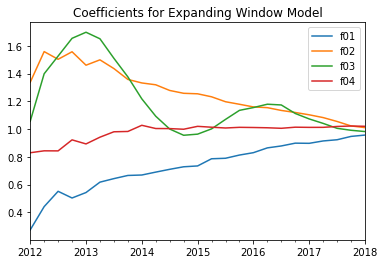

In [22]:
def extract_coefs(models):
    coefs = pd.DataFrame()
    for i, model in enumerate(models):
        model_coefs = pd.Series(model.coef_ ,index=['f01','f02','f03','f04']) #extract coefficients for model
        model_coefs.name = models.index[i] # name it with the recalc date
        coefs = pd.concat([coefs, model_coefs], axis=1)
        print(coefs.T)
    return coefs.T
extract_coefs(models).plot(title='Coefficients for Expanding Window Model')

/Users/taejunpark/.pyenv/versions/3.7.7/envs/dp/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


Training on the most recent 310 records
Coefficients: [0.27233504 1.33719756 1.05585533 0.82908026]
Training on the most recent 315 records
Coefficients: [0.60701665 1.76577809 1.73910068 0.86215854]
Training on the most recent 315 records
Coefficients: [0.80869519 1.37900782 1.75386011 0.8547622 ]
Training on the most recent 305 records
Coefficients: [0.37488934 1.74092815 2.04937842 1.21335292]
Training on the most recent 305 records
Coefficients: [0.68918299 1.09676184 1.89696154 0.81061842]
Training on the most recent 320 records
Coefficients: [1.03736466 1.74689522 1.456171   1.15014413]
Training on the most recent 315 records
Coefficients: [0.78826387 1.19604187 0.62723448 1.24240647]
Training on the most recent 315 records
Coefficients: [0.81542749 0.91478974 0.39038882 0.97619516]
Training on the most recent 310 records
Coefficients: [ 0.81336361  1.1255599  -0.26006146  1.22530876]
Training on the most recent 315 records
Coefficients: [ 0.88588876  1.24984194 -0.06327756  0.85

date
2012-03-31    LinearRegression()
2012-06-30    LinearRegression()
2012-09-30    LinearRegression()
2012-12-31    LinearRegression()
2013-03-31    LinearRegression()
2013-06-30    LinearRegression()
2013-09-30    LinearRegression()
2013-12-31    LinearRegression()
2014-03-31    LinearRegression()
2014-06-30    LinearRegression()
2014-09-30    LinearRegression()
2014-12-31    LinearRegression()
2015-03-31    LinearRegression()
2015-06-30    LinearRegression()
2015-09-30    LinearRegression()
2015-12-31    LinearRegression()
2016-03-31    LinearRegression()
2016-06-30    LinearRegression()
2016-09-30    LinearRegression()
2016-12-31    LinearRegression()
2017-03-31    LinearRegression()
2017-06-30    LinearRegression()
2017-09-30    LinearRegression()
2017-12-31    LinearRegression()
2018-03-31    LinearRegression()
Freq: Q-DEC, dtype: object


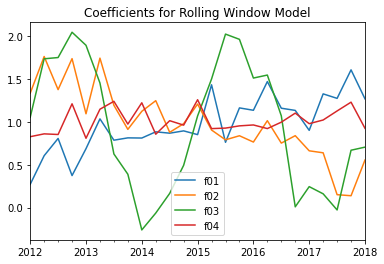

In [49]:
recalc_dates = features.resample('Q',level='date').mean().index

models = pd.Series(index=recalc_dates)
for date in recalc_dates:
    X_train = features.xs(slice(date-pd.Timedelta('90 days'), date),level='date',drop_level=False)
    y_train = outcome.xs(slice(date-pd.Timedelta('90 days'), date),level='date',drop_level=False)
    model = LinearRegression()
    model.fit(X_train,y_train)
    models.loc[date] = model
    
    print("Training on the most recent {} records".format(len(y_train)))
    print("Coefficients: {}".format((model.coef_)))
    
extract_coefs(models).plot(title='Coefficients for Rolling Window Model')

In [52]:
begin_dates = models.index
end_dates = models.index[1:].append(pd.to_datetime(['2099-12-31']))

predictions = pd.Series(index=features.index)

for i,model in enumerate(models): #loop thru each models object in collection
    X = features.xs(slice(begin_dates[i],end_dates[i]),level='date',drop_level=False)
    if X.shape[0] != 0: 
        p = pd.Series(model.predict(X),index=X.index)
        predictions.loc[X.index] = p
        print(predictions.head())

date        symbol
2012-01-03  AAPL     NaN
            AMZN     NaN
            CSCO     NaN
            MSFT     NaN
            YHOO     NaN
dtype: float64
date        symbol
2012-01-03  AAPL     NaN
            AMZN     NaN
            CSCO     NaN
            MSFT     NaN
            YHOO     NaN
dtype: float64
date        symbol
2012-01-03  AAPL     NaN
            AMZN     NaN
            CSCO     NaN
            MSFT     NaN
            YHOO     NaN
dtype: float64
date        symbol
2012-01-03  AAPL     NaN
            AMZN     NaN
            CSCO     NaN
            MSFT     NaN
            YHOO     NaN
dtype: float64
date        symbol
2012-01-03  AAPL     NaN
            AMZN     NaN
            CSCO     NaN
            MSFT     NaN
            YHOO     NaN
dtype: float64
date        symbol
2012-01-03  AAPL     NaN
            AMZN     NaN
            CSCO     NaN
            MSFT     NaN
            YHOO     NaN
dtype: float64
date        symbol
2012-01-03  AAPL     NaN
  

/Users/taejunpark/.pyenv/versions/3.7.7/envs/dp/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


In [53]:
models_expanding_window = pd.Series(index=recalc_dates)
for date in recalc_dates:
    X_train = features.xs(slice(None,date),level='date',drop_level=False)
    y_train = outcome.xs(slice(None,date),level='date',drop_level=False)
    model = LinearRegression()
    model.fit(X_train,y_train)
    models_expanding_window.loc[date] = model
    
models_rolling_window = pd.Series(index=recalc_dates)
for date in recalc_dates:
    X_train = features.xs(slice(date-pd.Timedelta('90 days'),date),level='date',drop_level=False)
    y_train = outcome.xs(slice(date-pd.Timedelta('90 days'),date),level='date',drop_level=False)
    model = LinearRegression()
    model.fit(X_train,y_train)
    models_rolling_window.loc[date] = model
    
begin_dates = models.index
end_dates = models.index[1:].append(pd.to_datetime(['2099-12-31']))
print(begin_dates[0], end_dates[0])

predictions_expanding_window = pd.Series(index=features.index)
for i,model in enumerate(models_expanding_window): #loop thru each models object in collection
    X = features.xs(slice(begin_dates[i],end_dates[i]),level='date',drop_level=False)
    if X.shape[0] != 0:
        p = pd.Series(model.predict(X),index=X.index)
    predictions_expanding_window.loc[X.index] = p
    
predictions_rolling_window = pd.Series(index=features.index)
for i,model in enumerate(models_rolling_window): #loop thru each models object in collection
    X = features.xs(slice(begin_dates[i],end_dates[i]),level='date',drop_level=False)
    if X.shape[0] != 0:
        p = pd.Series(model.predict(X),index=X.index)
    predictions_rolling_window.loc[X.index] = p

/Users/taejunpark/.pyenv/versions/3.7.7/envs/dp/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.
/Users/taejunpark/.pyenv/versions/3.7.7/envs/dp/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  if __name__ == '__main__':
/Users/taejunpark/.pyenv/versions/3.7.7/envs/dp/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2012-03-31 00:00:00 2012-06-30 00:00:00


/Users/taejunpark/.pyenv/versions/3.7.7/envs/dp/lib/python3.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [36]:
from sklearn.metrics import r2_score

common_idx = outcome.dropna().index.intersection(predictions_expanding_window.dropna().index)
rsq_expanding = r2_score(y_true = outcome[common_idx],y_pred=predictions_expanding_window[common_idx])
rsq_rolling = r2_score(y_true = outcome[common_idx],y_pred=predictions_rolling_window[common_idx])

print("Expanding Window RSQ: {}".format(round(rsq_expanding,3)))
print("Rolling Window RSQ: {}".format(round(rsq_rolling,3)))

Expanding Window RSQ: 0.266
Rolling Window RSQ: 0.14


In [37]:
from sklearn.tree import DecisionTreeRegressor

split_point = int(0.80*len(outcome))

X_train = features.iloc[:split_point,:] 
y_train = outcome.iloc[:split_point] 
X_test = features.iloc[split_point:,:] 
y_test = outcome.iloc[split_point:] 

model = DecisionTreeRegressor(max_depth=3)
model.fit(X=X_train,y=y_train)

print('RSQ in sample: '+str(round(model.score(X=X_train,y=y_train),3)))
print('RSQ out of sample: '+str(round(model.score(X=X_test,y=y_test),3)))

RSQ in sample: 0.174
RSQ out of sample: 0.03


In [38]:
recalc_dates = features.resample('Q',level='date').mean().index

models_rolling_window = pd.Series(index=recalc_dates)
for date in recalc_dates:
    X_train = features.xs(slice(date-pd.Timedelta('365 days'),date),level='date',drop_level=False)
    y_train = outcome.xs(slice(date-pd.Timedelta('365 days'),date),level='date',drop_level=False)
    model = DecisionTreeRegressor(max_depth=3)
    model.fit(X_train,y_train)
    models_rolling_window.loc[date] = model
    
predictions_rolling_window = pd.Series(index=features.index)
for i,model in enumerate(models_rolling_window): #loop thru each models object in collection
    X = features.xs(slice(begin_dates[i],end_dates[i]),level='date',drop_level=False)
    p = pd.Series(model.predict(X),index=X.index)
    predictions_rolling_window.loc[X.index] = p

common_idx = y_test.dropna().index.intersection(predictions_rolling_window.dropna().index)
rsq_rolling = r2_score(y_true = y_test[common_idx],y_pred=predictions_rolling_window[common_idx])
print("RSQ out of sample (rolling): {}".format(round(rsq_rolling,3)))

/Users/taejunpark/.pyenv/versions/3.7.7/envs/dp/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/taejunpark/.pyenv/versions/3.7.7/envs/dp/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  # This is added back by InteractiveShellApp.init_path()


RSQ out of sample (rolling): 0.103
